# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

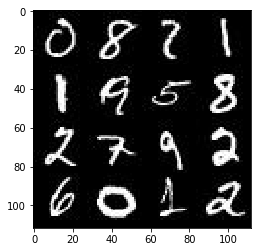

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

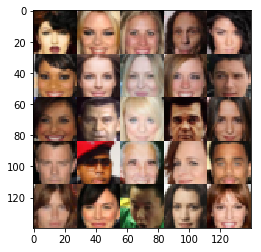

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = tf.placeholder(tf.float32, name='lr')
    tensor_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='tensor_real')
    tensor_z = tf.placeholder(tf.float32, (None, z_dim), name='tensor_z')
    return tensor_real, tensor_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
         # Input layer is 28x28x3
        #print(images.shape)
        x1 = tf.layers.conv2d(images, 32, 3, strides=1, padding='same')#27*27*32
        x1 =  tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same')#14*14*64
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 =  tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=1, padding='valid')#9*9*128
        x3 = tf.layers.batch_normalization(x3, training=True)
        tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d(x3, 256, 3, strides=2, padding='same')#5*5*256
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 =  tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d(x4, 512, 3, strides=1, padding='valid')#3*3*512
        x5 = tf.layers.batch_normalization(x4, training=True)
        x5 =  tf.maximum(alpha * x4, x4)
        
        flatten_dim = x5.get_shape()[1]*x3.get_shape()[2]*x3.get_shape()[3]
        #print(int(flatten_dim))
        flatten  = tf.reshape(x3, (-1,int(flatten_dim)))
        #print(flatten.shape)
        logits = tf.layers.dense(flatten,1)
        #print(logits.shape)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, reuse = False, alpha=0.2, train = True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # print(out_channel_dim)
        # First fully connected layer
        x1 = tf.layers.dense(z, 512*1*1)
        x1 = tf.reshape(x1, (-1, 1, 1, 512))
        x1 = tf.layers.batch_normalization(x1, training=train)
        x1 =  tf.maximum(alpha * x1, x1)#1*1*512
        
        # second conv layer
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=7, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=train)
        x2 =  tf.maximum(alpha * x2, x2)#7*7*512
        
        # third conv layer
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=train)
        x3 =  tf.maximum(alpha * x3, x3)#14*14*256
        
        # forth conv layer
        x4 = tf.layers.conv2d_transpose(x3, 512, 5, strides=1, padding="same")
        x4 = tf.layers.batch_normalization(x4, training=train)
        x4 =  tf.maximum(alpha * x4, x4)#14*14*512
        # print(x3.shape)
        
        # output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding="same") #28*28*out_channel_dim     
        out = tf.tanh(logits)
        #print(out.shape)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

AssertionError: tf.variable_scope called with wrong arguments in Generator Inference(reuse=True)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim,reuse=True, train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tensor_real, tensor_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(tensor_real, tensor_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                #print(type(learning_rate))
                # sample random noise for generator
                batch_z = np.random.uniform(1,-1,size = (batch_size, z_dim))
                
                # run optimizer
                
                _ = sess.run(d_train_opt, feed_dict={tensor_real: batch_images, tensor_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={tensor_real: batch_images, tensor_z:batch_z, lr:learning_rate})
                
                if step % 10 == 0:
                    train_d_loss = d_loss.eval({tensor_real:batch_images, tensor_z: batch_z})
                    train_g_loss = g_loss.eval({tensor_z:batch_z})
                    print("Step {}, Epoch {}/{}...".format(step, epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    losses.append((train_d_loss, train_g_loss))
                    
                if step%100 == 0:
                    show_generator_output(sess, batch_size, tensor_z, data_shape[3], data_image_mode)
                
    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 3.0313
Step 20, Epoch 1/2... Discriminator Loss: 0.4722... Generator Loss: 3.4214
Step 30, Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 5.0461
Step 40, Epoch 1/2... Discriminator Loss: 1.6639... Generator Loss: 0.4850
Step 50, Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.9741
Step 60, Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 1.1563
Step 70, Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 0.8676
Step 80, Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 2.1605
Step 90, Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.9641
Step 100, Epoch 1/2... Discriminator Loss: 0.7596... Generator Loss: 1.4164


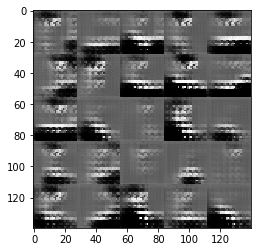

Step 110, Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 1.0695
Step 120, Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.0256
Step 130, Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 2.6567
Step 140, Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 1.0917
Step 150, Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 1.2435
Step 160, Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.8171
Step 170, Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 1.4694
Step 180, Epoch 1/2... Discriminator Loss: 0.7635... Generator Loss: 1.8280
Step 190, Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 1.8444
Step 200, Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.2498


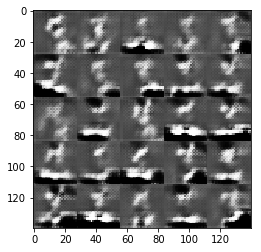

Step 210, Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.6001
Step 220, Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.5090
Step 230, Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 1.3601
Step 240, Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 1.1559
Step 250, Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 2.2449


KeyboardInterrupt: 

In [20]:
batch_size = 32
z_dim = 200
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10, Epoch 1/1... Discriminator Loss: 7.2692... Generator Loss: 0.0015
Step 20, Epoch 1/1... Discriminator Loss: 6.6400... Generator Loss: 0.0086
Step 30, Epoch 1/1... Discriminator Loss: 5.7716... Generator Loss: 0.0064
Step 40, Epoch 1/1... Discriminator Loss: 5.3352... Generator Loss: 0.0087
Step 50, Epoch 1/1... Discriminator Loss: 3.3893... Generator Loss: 0.0737
Step 60, Epoch 1/1... Discriminator Loss: 2.0859... Generator Loss: 0.2572
Step 70, Epoch 1/1... Discriminator Loss: 2.2900... Generator Loss: 0.2330
Step 80, Epoch 1/1... Discriminator Loss: 1.7115... Generator Loss: 0.6691
Step 90, Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 0.4663
Step 100, Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.5981


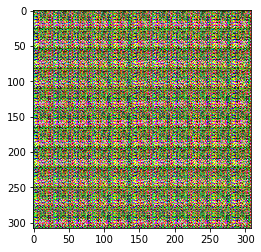

Step 110, Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.0915
Step 120, Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.9300
Step 130, Epoch 1/1... Discriminator Loss: 1.8852... Generator Loss: 0.7427
Step 140, Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.1247
Step 150, Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.4394
Step 160, Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.4598
Step 170, Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.9328
Step 180, Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.6843
Step 190, Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.4633
Step 200, Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 1.6899


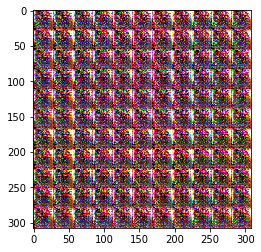

Step 210, Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 2.3798
Step 220, Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.6864
Step 230, Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 2.6223
Step 240, Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.1753
Step 250, Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 3.2634
Step 260, Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.9803
Step 270, Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 2.1202
Step 280, Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 2.2954
Step 290, Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.5595
Step 300, Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 1.8192


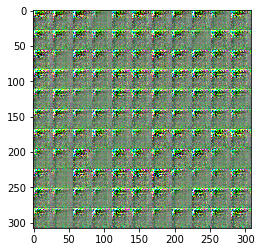

Step 310, Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 1.8477
Step 320, Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 2.9487
Step 330, Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.7421
Step 340, Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9764
Step 350, Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.0047
Step 360, Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.1882
Step 370, Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.3880
Step 380, Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 2.4764
Step 390, Epoch 1/1... Discriminator Loss: 2.0839... Generator Loss: 2.1852
Step 400, Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 1.9923


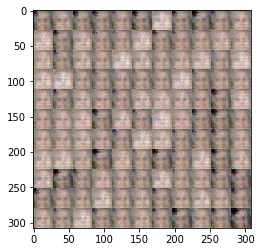

Step 410, Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 3.5753
Step 420, Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.6105
Step 430, Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.3777
Step 440, Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9858
Step 450, Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 0.9574
Step 460, Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.2665
Step 470, Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.6066
Step 480, Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.4481
Step 490, Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6930
Step 500, Epoch 1/1... Discriminator Loss: 2.2871... Generator Loss: 0.4774


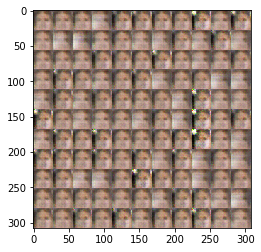

Step 510, Epoch 1/1... Discriminator Loss: 1.7039... Generator Loss: 0.7482
Step 520, Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.3111
Step 530, Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7459
Step 540, Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.1533
Step 550, Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5302
Step 560, Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.4462
Step 570, Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6370
Step 580, Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9775
Step 590, Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 2.3889
Step 600, Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.8452


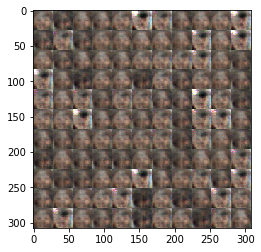

Step 610, Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.9453
Step 620, Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 2.8565
Step 630, Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.9168
Step 640, Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6208
Step 650, Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 2.9659
Step 660, Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1390
Step 670, Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.6643
Step 680, Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.7390
Step 690, Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.7119
Step 700, Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 1.7571


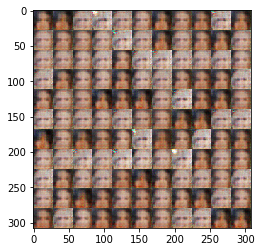

Step 710, Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7791
Step 720, Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.1009
Step 730, Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.3441
Step 740, Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.0758
Step 750, Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.7220
Step 760, Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.1280
Step 770, Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 4.8756
Step 780, Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 2.3338
Step 790, Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9220
Step 800, Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 2.0725


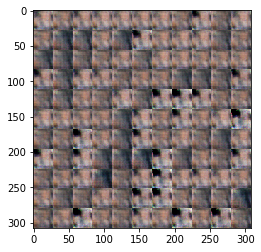

Step 810, Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.3310
Step 820, Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 0.9931
Step 830, Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.5024
Step 840, Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 1.9673
Step 850, Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 2.1101
Step 860, Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.9416
Step 870, Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.9506
Step 880, Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.7648
Step 890, Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 1.8693
Step 900, Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.1585


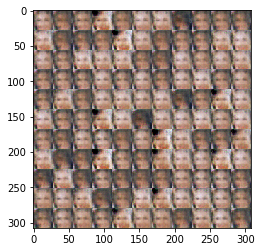

Step 910, Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.7246
Step 920, Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 5.9213
Step 930, Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.3903
Step 940, Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.7612
Step 950, Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.1792
Step 960, Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.9200
Step 970, Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 2.2558
Step 980, Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 5.3782
Step 990, Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 2.7779
Step 1000, Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 3.3765


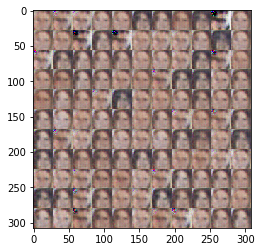

Step 1010, Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.7204
Step 1020, Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.7656
Step 1030, Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.9864
Step 1040, Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 2.0808
Step 1050, Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.4146
Step 1060, Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.2810
Step 1070, Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.6044
Step 1080, Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.2488
Step 1090, Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 3.1894
Step 1100, Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 2.1945


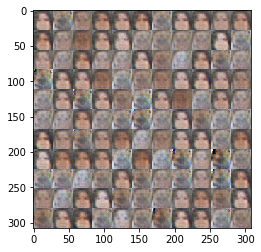

Step 1110, Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 2.4854
Step 1120, Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 1.7634
Step 1130, Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.8410
Step 1140, Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.3034
Step 1150, Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 5.2915
Step 1160, Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.9138
Step 1170, Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 7.3450
Step 1180, Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 2.5342
Step 1190, Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 2.5649
Step 1200, Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 4.0201


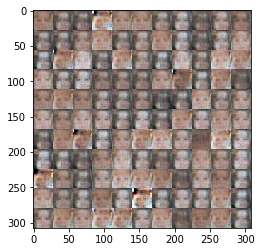

Step 1210, Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 2.9783
Step 1220, Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 9.4209
Step 1230, Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 2.8036
Step 1240, Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 3.0791
Step 1250, Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.3929
Step 1260, Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.4987
Step 1270, Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.0846
Step 1280, Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 7.5775
Step 1290, Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 2.8425
Step 1300, Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 4.0661


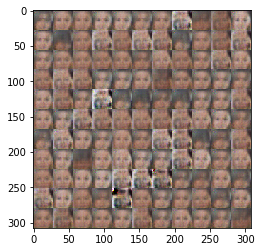

Step 1310, Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.1414
Step 1320, Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 2.7118
Step 1330, Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.9565
Step 1340, Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.1833
Step 1350, Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 2.8864
Step 1360, Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.6715
Step 1370, Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.5564
Step 1380, Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.6012
Step 1390, Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 6.4206
Step 1400, Epoch 1/1... Discriminator Loss: 5.2773... Generator Loss: 6.2828


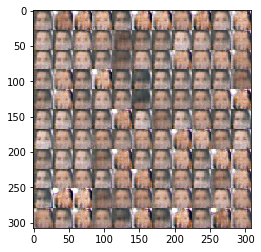

Step 1410, Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.6337
Step 1420, Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 1.8322
Step 1430, Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.4979
Step 1440, Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.6603
Step 1450, Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.6640
Step 1460, Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.3172
Step 1470, Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7353
Step 1480, Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.3782
Step 1490, Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.9677
Step 1500, Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 2.9221


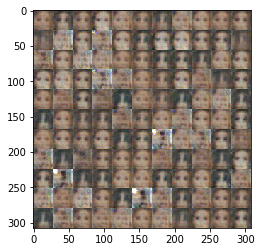

Step 1510, Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 1.8964
Step 1520, Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.7049
Step 1530, Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.2084
Step 1540, Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 7.0785
Step 1550, Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.3644
Step 1560, Epoch 1/1... Discriminator Loss: 0.3931... Generator Loss: 3.2342
Step 1570, Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 3.1607
Step 1580, Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 3.2849


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 2e-4
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.